In [ ]:
!pip install -q segmentation-models==1.0.1
!pip install -U albumentations>=0.3.0 --user 
!pip install -q keras==2.3.1
!pip install -q tensorflow==2.1.0
!pip install -q keras_applications==1.0.8
!pip install -q image-classifiers==1.0.0
!pip install -q efficientnet==1.0.0

     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 378kB 8.2MB/s 
     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 3.9MB 51.4MB/s 
     |████████████████████████████████| 450kB 55.3MB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm

In [ ]:
x_train_dir = '/content/train_images'
y_train_dir = '/content/train_masks'

x_valid_dir = '/content/valid_images'
y_valid_dir = '/content/valid_masks'

x_test_dir = '/content/test_images'

In [ ]:
IMG_WIDTH = 512
IMG_HEIGHT = 256

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
class Dataset:

    CLASSES = ['back','lane']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i],0)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(IMG_WIDTH,IMG_HEIGHT))
    
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,(IMG_WIDTH,IMG_HEIGHT))
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return (image, mask)
        
    def __len__(self):
        return len(self.ids)

class Dataloder(keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)        

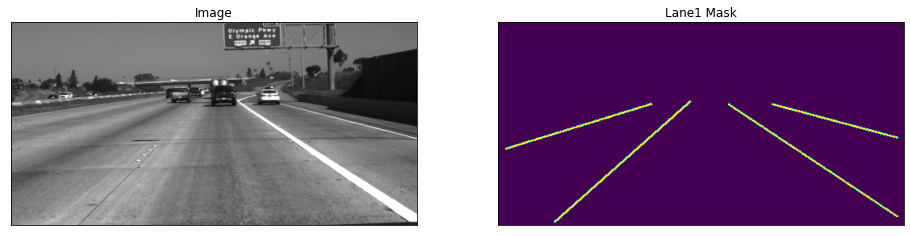

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['lane'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    lane1_mask=mask[..., 0].squeeze(),
)

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=IMG_HEIGHT, min_width=IMG_WIDTH, always_apply=True, border_mode=0),
        
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(IMG_HEIGHT, IMG_WIDTH)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

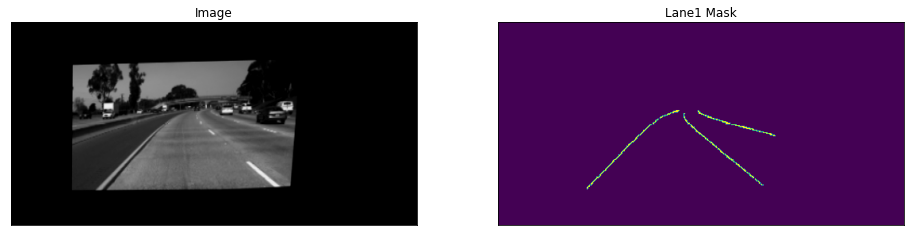

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['lane'], augmentation=get_training_augmentation())

image, mask = dataset[12]
visualize(
    image=image, 
    lane1_mask=mask[..., 0].squeeze(),
)

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['lane']
LR = 0.0001
EPOCHS = 200

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
n_classes = 1
activation = 'sigmoid'

model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [ ]:
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim,total_loss, metrics)

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
dataset = Dataset(x_valid_dir,y_valid_dir, classes=['lane'], augmentation=get_training_augmentation())

In [ ]:
import random
class DisplayCallback(keras.callbacks.Callback)
      def on_epoch_end(self, epoch, logs=None)           image_sample, mask_sample = dataset[random.randint(0,256            image_p = preprocess_input(image_samp        
    image_p = np.expand_dims(image_p, axi        
    pr_mask = model.predict(image_p).rou        

    vis            
        image=image_sample.sq            
        gt_mask=mask_sample[..., 0].s            ,
        pr_mask=pr_mask[..., 0emat(epoch+1))

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min', verbose=1),
    keras.callbacks.ReduceLROnPlateau(verbose=1,patience=6),
    keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    DisplayCallback()
]

In [ ]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('model.h5',include_optimizer=False)